In [1]:
# SISO 5G gNB-UE Simulation using AIRSTRAN D 2200
import os

# Import or install Sionna
try:
    import sionna.rt
except ImportError as e:
    import os
    os.system("pip install sionna-rt")
    import sionna.rt

# Other imports
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import mitsuba as mi
import warnings

# Suppress warnings
warnings.filterwarnings("ignore", message="invalid value encountered in multiply")
warnings.filterwarnings("ignore", category=UserWarning, module="jupyter_client")

# Import relevant components from Sionna RT
from sionna.rt import load_scene, Transmitter, Receiver, Transmitter, Camera, PathSolver
from sionna.rt import AntennaArray, PlanarArray, SceneObject, ITURadioMaterial
from sionna.rt.antenna_pattern import antenna_pattern_registry

scene_xml_path = "../scene/scenes/Duke/scene.xml"
# Load empty scene
scene = load_scene(scene_xml_path)
# Set the operating frequency (n48 band for 5G)

2026-02-20 18:09:22 WARN  [HDRFilm] Monochrome mode enabled, setting film output pixel format to 'luminance' (was rgb).


In [2]:
import sys
import os

# Add the src directory to the Python path
sys.path.append(os.path.abspath('../src'))

In [3]:
# Install plyfile if not available
try:
    from plyfile import PlyData
except ImportError:
    import os
    os.system("pip install plyfile")
    from plyfile import PlyData

In [4]:
# ============================================
# SISO Configuration: gNB to UE
# ============================================

scene.frequency = 5.0e9  # 3.7 GHz

# Define UE position (fixed to start)
ue_position = [10.0, 0.0, 0.0]   # UE position (x, y, z in meters)

# ============================================
# Antenna Configuration
# ============================================

# gNB antenna: 3GPP TR 38.901 pattern (AIRSTRAN D 2200)
gnb_pattern_factory = antenna_pattern_registry.get("tr38901")
gnb_pattern = gnb_pattern_factory(polarization="V")

# UE antenna: Isotropic pattern (typical for mobile devices)
# This will be required for matching the calculations of the RadioMapSolver()
ue_pattern_factory = antenna_pattern_registry.get("iso")
# Polarization should also match the transmitter
ue_pattern = ue_pattern_factory(polarization="V")

# SISO: Single antenna element at origin [0, 0, 0] for both TX and RX
single_element = np.array([[0.0, 0.0, 0.0]])  # Shape: (1, 3)

# Configure antenna arrays
scene.tx_array = AntennaArray(
    antenna_pattern=gnb_pattern,
    normalized_positions=single_element.T  # Shape: (3, 1)
)

scene.rx_array = AntennaArray(
    antenna_pattern=ue_pattern,
    normalized_positions=single_element.T  # Shape: (3, 1)
)

# ============================================
# Add Receiver to Scene
# ============================================

# Create UE receiver
rx = Receiver(name="ue", position=ue_position, display_radius=0.03)
scene.add(rx)

# ============================================
# Configure Propagation Environment
# ============================================

# Disable scattering for basic simulation
for radio_material in scene.radio_materials.values():
    radio_material.scattering_coefficient = 0.4

Available buildings in scene: 154 total

Building 5:
  Rooftop height: 10.50 m
  X range: [-359.61, -268.82] m (center: -314.22)
  Y range: [85.82, 166.54] m (center: 126.18)
  Vertices: 23

Building 6:
  Rooftop height: 21.00 m
  X range: [108.98, 261.57] m (center: 185.27)
  Y range: [378.62, 491.15] m (center: 434.89)
  Vertices: 42

Building 7:
  Rooftop height: 17.50 m
  X range: [357.85, 476.71] m (center: 417.28)
  Y range: [316.22, 444.32] m (center: 380.27)
  Vertices: 11

Building 8:
  Rooftop height: 17.50 m
  X range: [298.98, 371.08] m (center: 335.03)
  Y range: [432.44, 520.85] m (center: 476.65)
  Vertices: 18

Building 9:
  Rooftop height: 17.50 m
  X range: [-316.06, -228.78] m (center: -272.42)
  Y range: [-109.71, -16.41] m (center: -63.06)
  Vertices: 6

Building 10:
  Rooftop height: 17.50 m
  X range: [185.39, 260.42] m (center: 222.91)
  Y range: [581.46, 634.82] m (center: 608.14)
  Vertices: 14

Building 11:
  Rooftop height: 10.50 m
  X range: [51.31, 115.30]

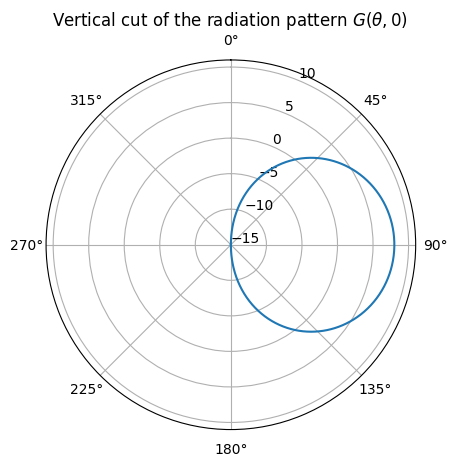

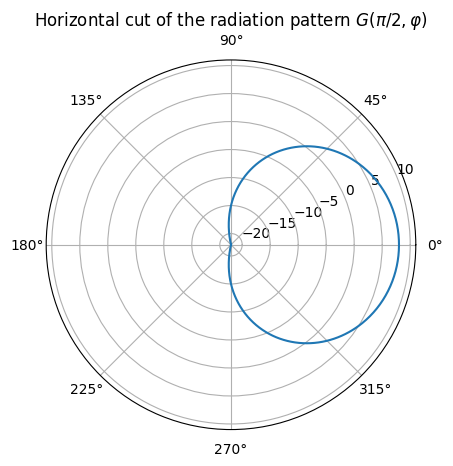

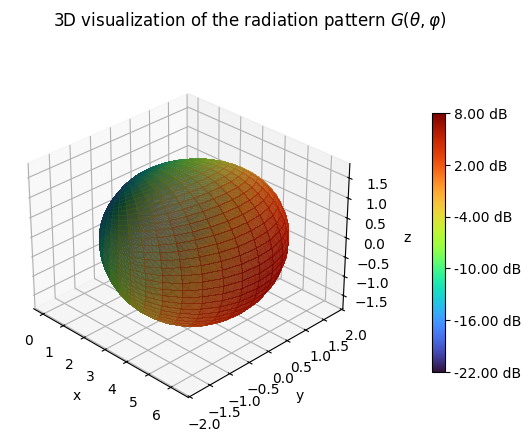

In [5]:
from scene_parser import extract_building_info
from tx_placement import TxPlacement
# ============================================
# Place gNB on a Specific Building
# ============================================

building_info = extract_building_info(scene_xml_path, verbose=True)

# Old: 46
selected_building_id = 37  # Change this to your desired building number

# TxPlacement will create the transmitter if it doesn't exist and place it on the building
# Correct parameter order: (scene, tx_name, scene_xml_path, building_id, offset)
tx_placer = TxPlacement(scene, "gnb", scene_xml_path, selected_building_id, offset=5.0)
tx_placer.set_rooftop_center()

# Get reference to the transmitter (already added to scene by TxPlacement)
tx = tx_placer.tx
# Convert to flat numpy array instead of nested list
gnb_position = tx.position.numpy().flatten().tolist()

# Point antenna toward UE
tx.look_at(ue_position)

print(f"\nSuccess! gNB placed on building {selected_building_id}")
print(f"Position: {gnb_position}")

# ============================================
# Compute Propagation Paths
# ============================================

# Instantiate path solver
p_solver = PathSolver()

# Compute propagation paths
paths = p_solver(
    scene=scene,
    max_depth=5,
    los=True,
    specular_reflection=True,
    diffuse_reflection=False,
    refraction=False,
    seed=41
)

# ============================================
# Visualize Scene
# ============================================

# Setup camera
cam = Camera(position=(100.0, 100.0, 50.0))
cam.look_at(gnb_position)

# Preview the scene with propagation paths
scene.preview(
    paths=paths,
    resolution=[1000, 1000],
    clip_at=200,
    show_orientations=True
)

gnb_pattern.show();

Zone contains 180518 grid cells
Zone coverage: 2.3% of map
Naive baseline look-at: [0.0, 200.0, 0.0]
Zone centroid: [0.26968778736746474, 212.04385712228142]



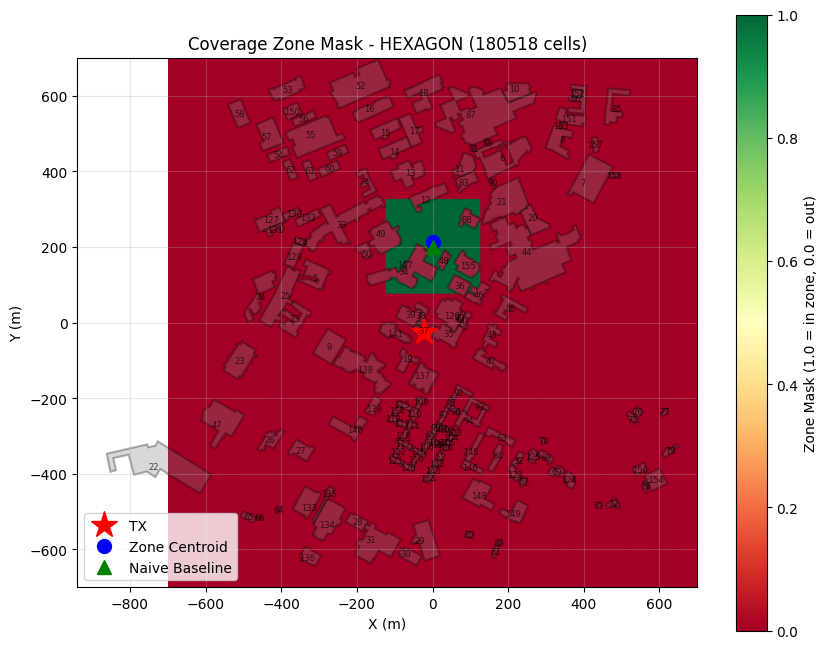

In [6]:
from boresight_pathsolver import (
    optimize_boresight_pathsolver,
    create_zone_mask
)
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as MPLPolygon
import numpy as np
import scipy
import scipy.stats.qmc as qmc

# Define the map configuration
map_config = {
    'center': [0.0, 0.0, 0.0],
    'size': [1400, 1400],
    'cell_size': (0.5, 0.5),
    'ground_height': 0.0,
}

# Hexagon vertices centered at [0, -200] with radius ~307
hexagon_vertices = [
    (0, 107),       # Top
    (266, -47),     # Top-right
    (266, -353),    # Bottom-right
    (0, -507),      # Bottom
    (-266, -353),   # Bottom-left
    (-266, -47)     # Top-left
]

# Complex irregular "splat" polygon centered at [-400.0, -150.0]
# More vertices for a smoother, more organic paint-splat shape
splat_vertices = [
    (-400.0 + 120.0, -150.0 + 140.0),   # Top protrusion peak
    (-400.0 + 95.0,  -150.0 + 110.0),   # Top protrusion right slope
    (-400.0 + 80.0,  -150.0 + 85.0),    # Top-right shoulder
    (-400.0 + 115.0, -150.0 + 65.0),    # Right bulge start
    (-400.0 + 160.0, -150.0 + 40.0),    # Right protrusion peak
    (-400.0 + 140.0, -150.0 + 10.0),    # Right protrusion lower
    (-400.0 + 90.0,  -150.0 - 20.0),    # Right side indent
    (-400.0 + 110.0, -150.0 - 55.0),    # Right lower bulge
    (-400.0 + 130.0, -150.0 - 110.0),   # Bottom-right protrusion
    (-400.0 + 85.0,  -150.0 - 130.0),   # Bottom-right slope
    (-400.0 + 20.0,  -150.0 - 150.0),   # Bottom protrusion peak
    (-400.0 - 35.0,  -150.0 - 145.0),   # Bottom center
    (-400.0 - 100.0, -150.0 - 120.0),   # Bottom-left slope
    (-400.0 - 135.0, -150.0 - 75.0),    # Left lower bulge
    (-400.0 - 150.0, -150.0 - 30.0),    # Left protrusion peak
    (-400.0 - 140.0, -150.0 + 10.0),    # Left protrusion upper
    (-400.0 - 110.0, -150.0 + 60.0),    # Left side upper
    (-400.0 - 70.0,  -150.0 + 90.0),    # Left-top bulge
    (-400.0 - 30.0,  -150.0 + 120.0),   # Top-left protrusion
    (-400.0 + 20.0,  -150.0 + 125.0),   # Top-left slope
]

# Use polygon format for zone_params (consistent across all functions)
zone_params = {
    'vertices': splat_vertices
}

zone_params = {
    'center': [0.0, 200.00],
    'width': 250,
    'height': 250
}

# Define the zone configuration using POLYGON instead of BOX
zone_mask, naive_look_at, zone_stats = create_zone_mask(
    map_config=map_config,
    zone_type='box',  # Changed from 'box' to 'polygon'
    origin_point=gnb_position,
    zone_params=zone_params,
    target_height=0.0,
    scene_xml_path=scene_xml_path,
    exclude_buildings=True
)
print(f"Zone contains {zone_stats['num_cells']} grid cells")
print(f"Zone coverage: {zone_stats['coverage_fraction']*100:.1f}% of map")
print(f"Naive baseline look-at: {zone_stats['look_at_xyz']}")
print(f"Zone centroid: {zone_stats['centroid_xy']}")
print()

# Visualize the Zone Mask
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(
    zone_mask,
    origin='lower',
    cmap='RdYlGn',
    extent=[
        map_config['center'][0] - map_config['size'][0]/2,
        map_config['center'][0] + map_config['size'][0]/2,
        map_config['center'][1] - map_config['size'][1]/2,
        map_config['center'][1] + map_config['size'][1]/2,
    ],
    vmin=0,
    vmax=1
)
plt.colorbar(im, ax=ax, label='Zone Mask (1.0 = in zone, 0.0 = out)')

# Add building polygons and labels
for building_id, bldg_data in building_info.items():
    # Extract XY coordinates (ignore Z for 2D plot)
    vertices_2d = bldg_data['vertices'][:, :2]  # Only take x, y columns

    # Create polygon patch with gray fill
    polygon = MPLPolygon(vertices_2d, closed=True, fill=True,
                         facecolor='gray', edgecolor='black', 
                         linewidth=1.5, alpha=0.3)
    ax.add_patch(polygon)

    # Calculate true centroid from vertices (not bounding box center)
    centroid_x = np.mean(vertices_2d[:, 0])
    centroid_y = np.mean(vertices_2d[:, 1])
    
    # Add building ID label at centroid
    ax.text(centroid_x, centroid_y, str(building_id),
            fontsize=6, fontweight='normal', ha='center', va='center',
            color='black', alpha=0.7)

ax.plot(gnb_position[0], gnb_position[1], 'r*', markersize=20, label='TX')
ax.plot(zone_stats['centroid_xy'][0], zone_stats['centroid_xy'][1], 'bo',
        markersize=10, label='Zone Centroid')
ax.plot(zone_stats['look_at_xyz'][0], zone_stats['look_at_xyz'][1], 'g^',
        markersize=10, label='Naive Baseline')
ax.set_title(f'Coverage Zone Mask - HEXAGON ({zone_stats["num_cells"]} cells)')
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

Transmit Power in dBm: 44.0
TX placement mode: skip (using current position)

Cached 10 building polygons for rejection sampling
Removing 1 existing receiver(s): ['ue']
Pre-creating 75 receivers...
  Created 75 receivers (will reposition each iteration)
Tx Position: [-23.77073860168457, -24.334800720214844, [15.5]]
look_at_position: [0.0, 200.0, 1.5]

PYTORCH TENSOR INITIALIZATION
PyTorch azimuth tensor initialized to: 83.95°
PyTorch elevation tensor initialized to: -3.55°
PyTorch tx_x tensor initialized to: -23.77m

STEP 1: Position parameters created but NOT being optimized yet
        Testing if passing through @dr.wrap breaks PathSolver



/home/tingjunlab/anaconda3/envs/g2sm/lib/python3.12/site-packages/torch/cuda/__init__.py:827: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")



STARTING OPTIMIZATION - Iteration 1/20
  Starting Azimuth: 83.95°
  Starting Elevation: -3.55°
  Starting Position [x]: [-23.7707] m
  Starting Position [y]: [-24.3348] m
TX orientation: [[1.46015, 0.0538559, 0]]
Tx position: [[-23.7707, -24.3348, 15.5]]


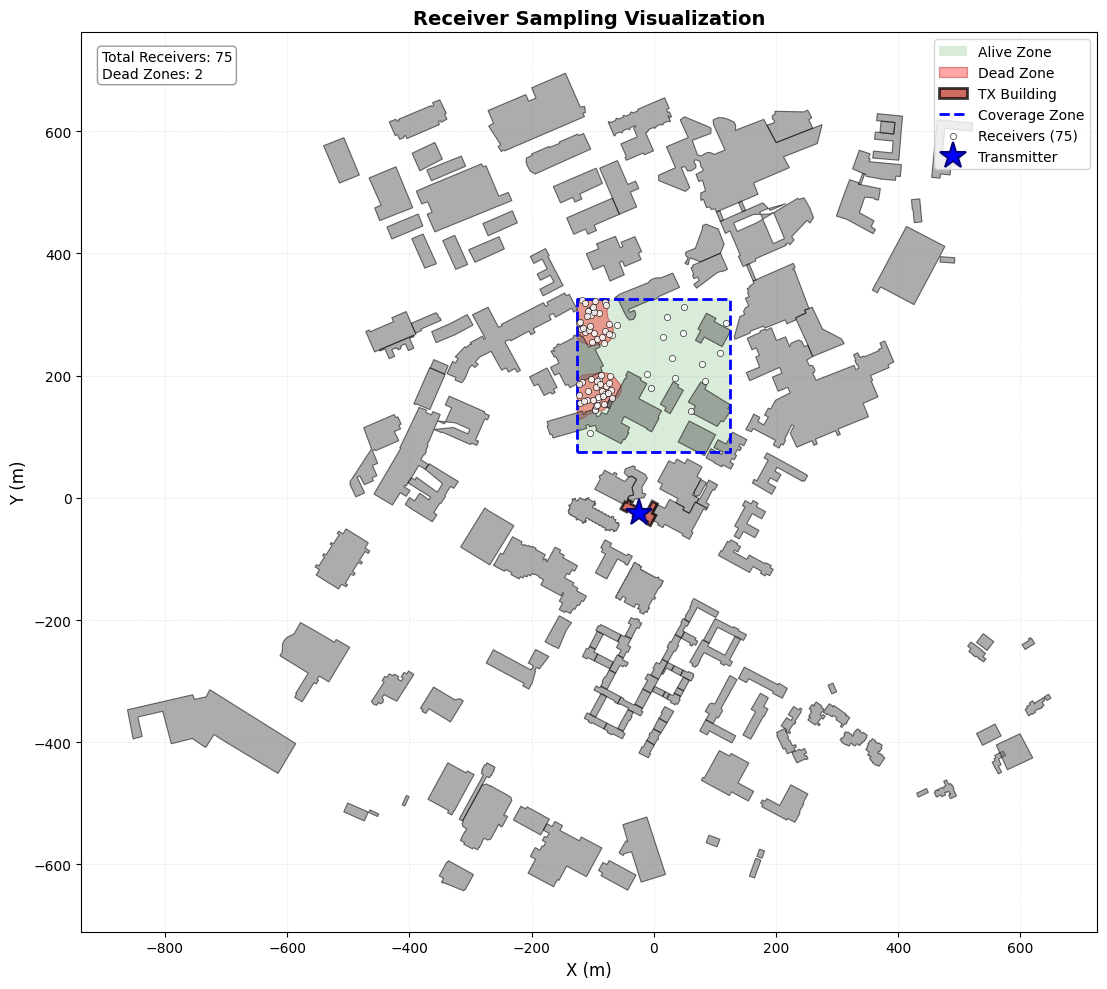

TX orientation: [[1.4822, 0.0596195, 0]]
Tx position: [[-23.6707, -24.4348, 15.5]]


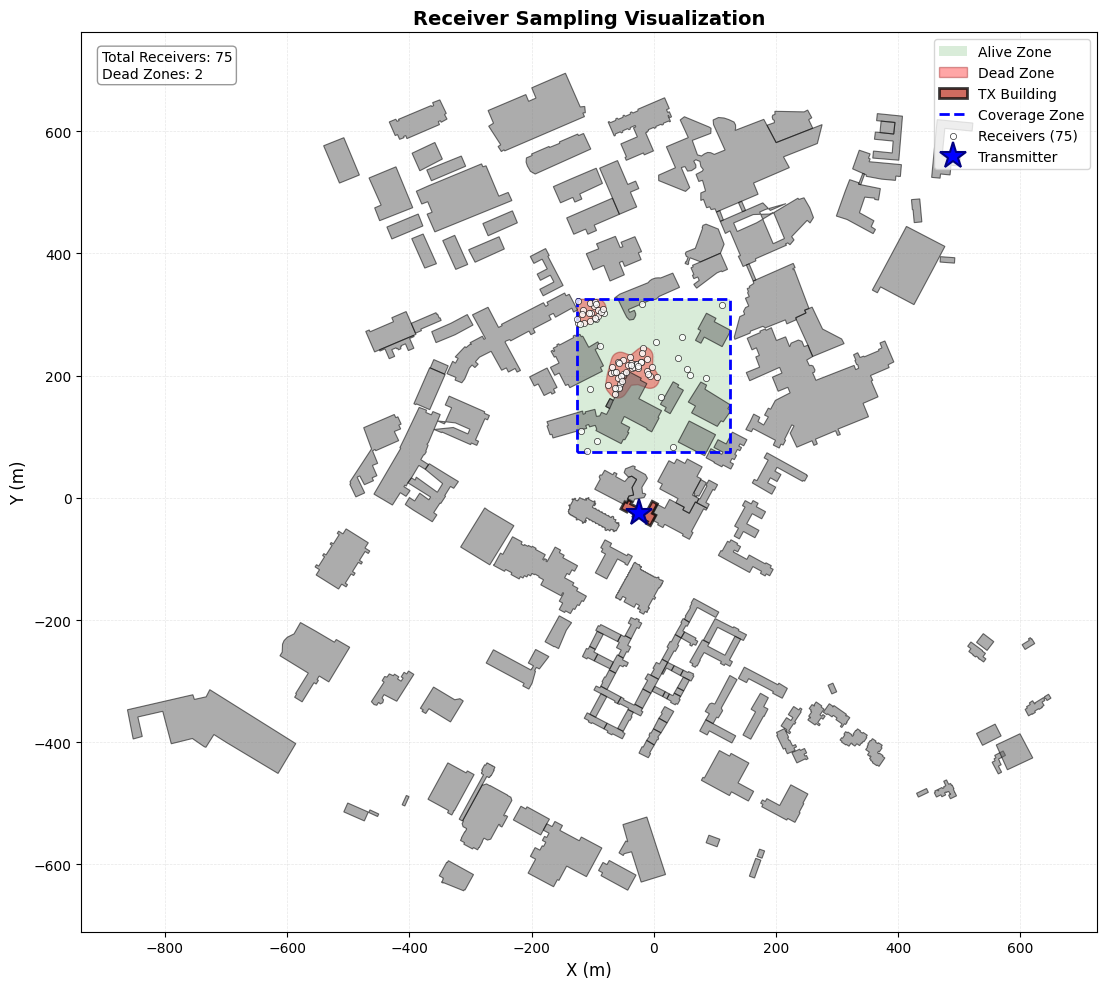

TX orientation: [[1.47254, 0.0502323, 0]]
Tx position: [[-23.5729, -24.5237, 15.5]]


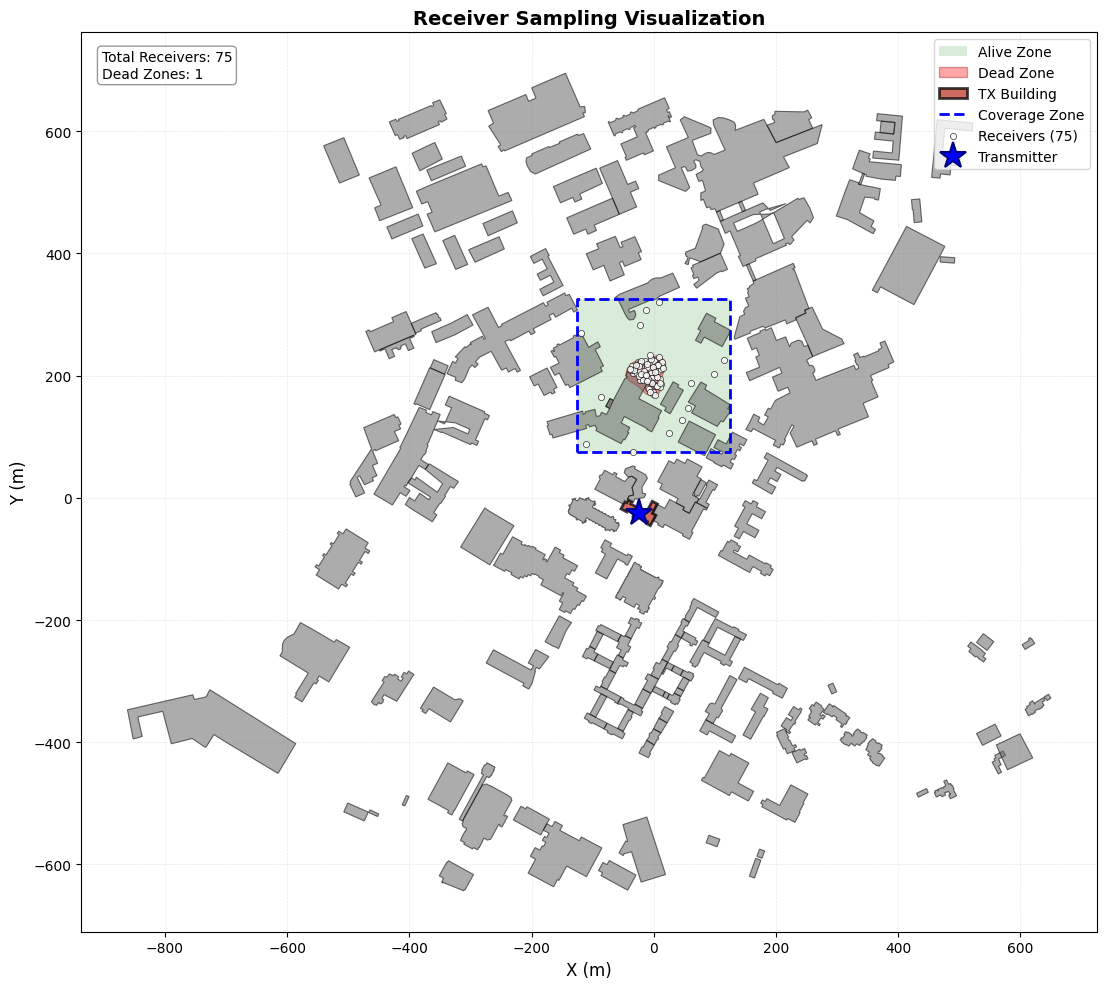

TX orientation: [[1.46792, 0.0548217, 0]]
Tx position: [[-23.4762, -24.6174, 15.5]]


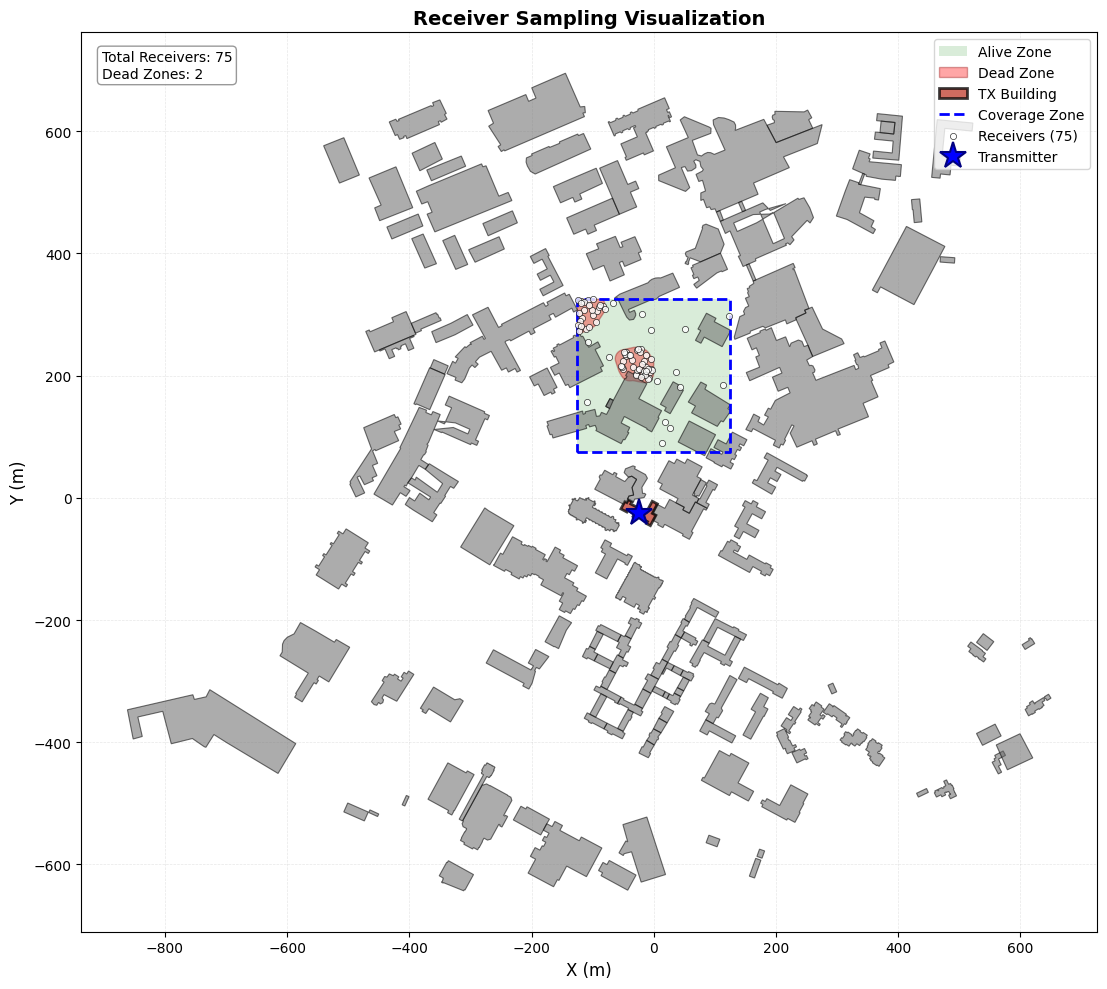

TX orientation: [[1.44357, 0.0625421, 0]]
Tx position: [[-23.3785, -24.7127, 15.5]]


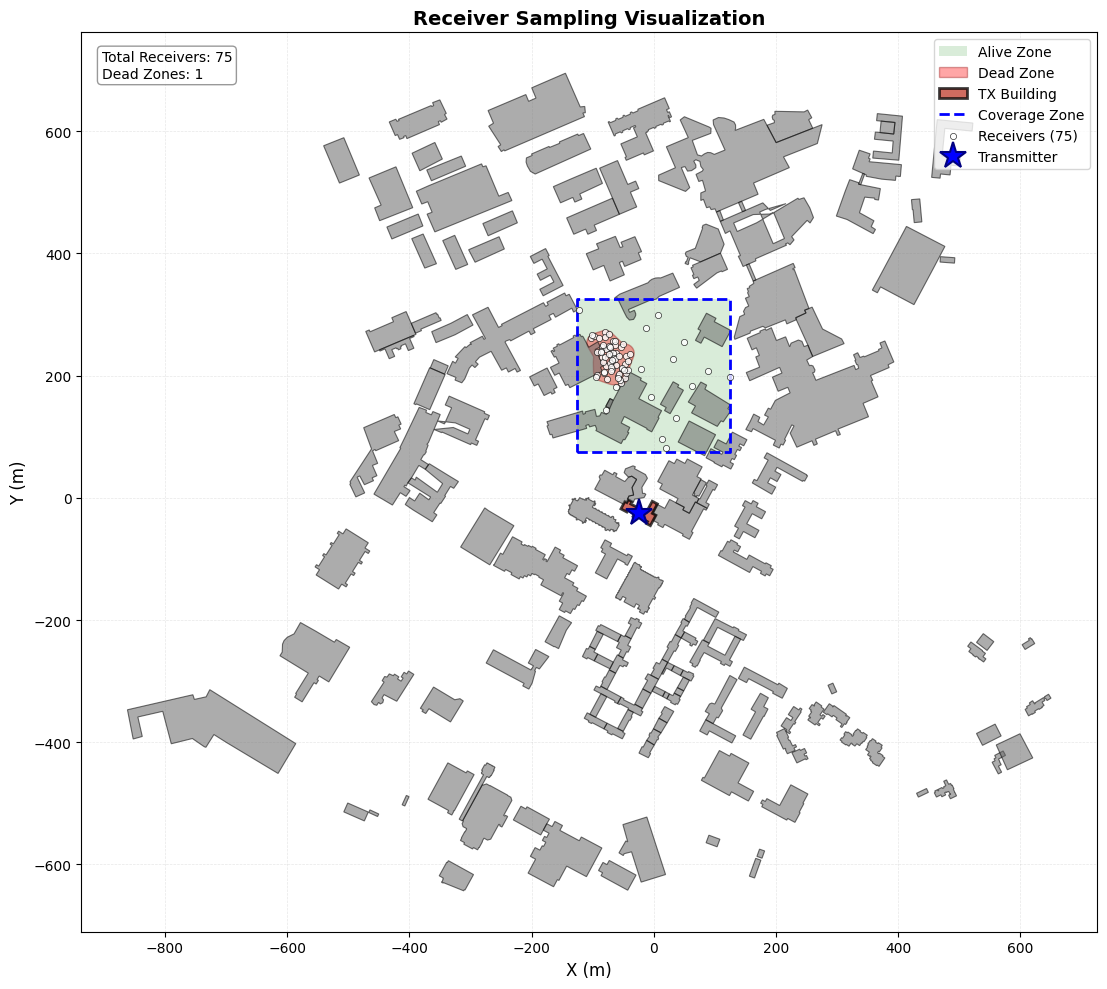

TX orientation: [[1.49171, 0.0356252, 0]]
Tx position: [[-23.3594, -24.8097, 15.5]]


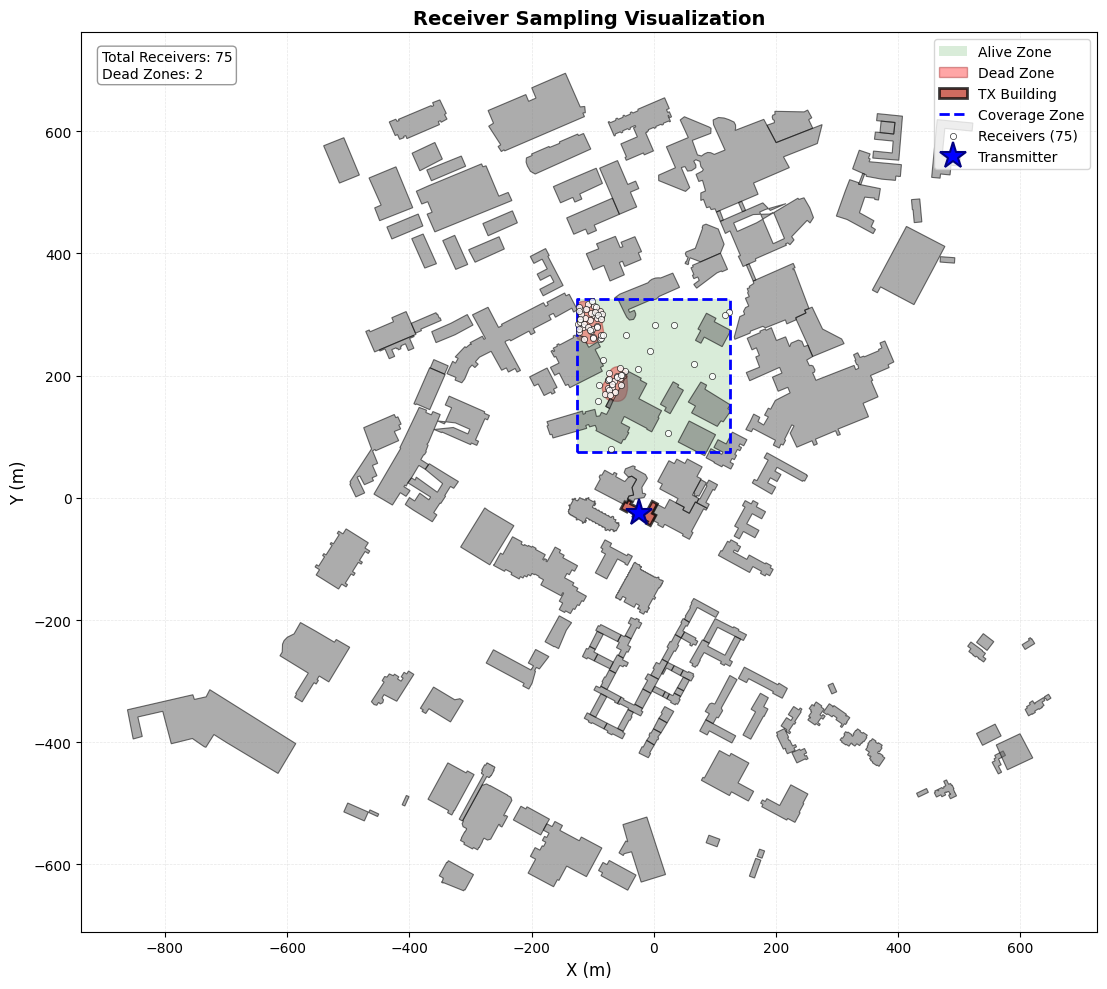

TX orientation: [[1.46895, 0.0440844, 0]]
Tx position: [[-23.3227, -24.9038, 15.5]]


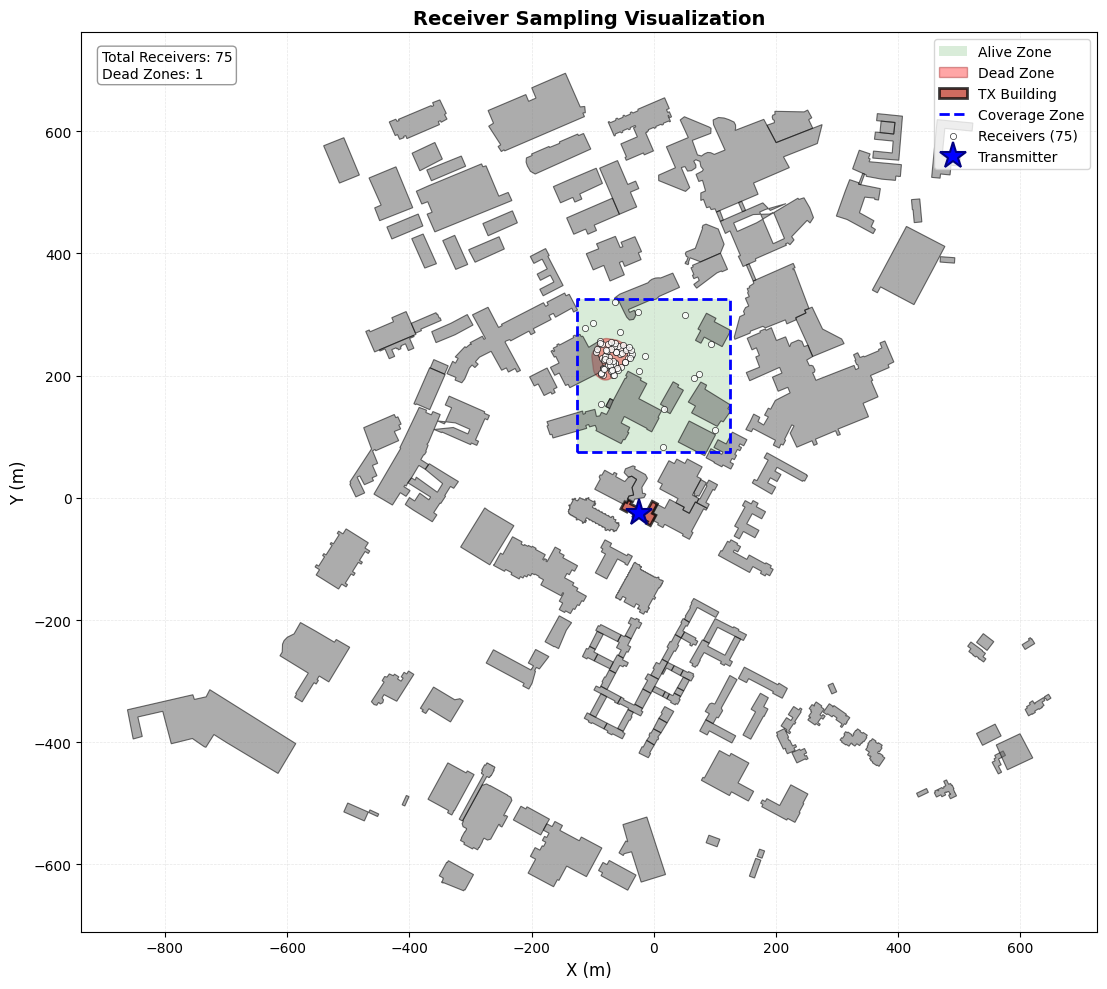

KeyboardInterrupt: 

In [ ]:
# ============================================
# Single-Run Optimization
# ============================================

from importlib import reload
import boresight_pathsolver as bp_module
reload(bp_module)
from boresight_pathsolver import optimize_boresight_pathsolver

result = optimize_boresight_pathsolver(
    scene=scene,
    tx_name="gnb",
    map_config=map_config,
    scene_xml_path=scene_xml_path,
    zone_params=zone_params,
    num_sample_points=100,
    building_id=selected_building_id,
    learning_rate=.1,
    num_iterations=20,
    verbose=True,
    lds="Latin",
)

(best_angles, loss_hist, angle_hist, grad_hist,
 cov_stats, initial_angles, initial_tx_pos, optimized_tx_pos) = result

#print(f"\nFinal loss: {loss_hist[-1]:.4f}")
print(f"Angles: Az={best_angles[0]:.1f}, El={best_angles[1]:.1f}")
print(f"Position: ({optimized_tx_pos[0]}, {optimized_tx_pos[1]})")

In [ ]:
from boresight_pathsolver import compare_boresight_performance
from angle_utils import azimuth_elevation_to_yaw_pitch, compute_initial_angles_from_position
import mitsuba as mi

# Compute naive angles from the naive look_at position
tx = scene.get("gnb")
tx_position = [
    float(tx.position[0][0]),
    float(tx.position[1][0]),
    float(tx.position[2][0])
]
print(tx_position)

# Convert naive look_at position to angles
naive_azimuth, naive_elevation = compute_initial_angles_from_position(
    tx_position, naive_look_at.tolist()
)
naive_angles = [naive_azimuth, naive_elevation]

print(f"Naive baseline angles: Azimuth={naive_azimuth:.1f}°, Elevation={naive_elevation:.1f}°")
print(f"Optimized angles: Azimuth={best_angles[0]:.1f}°, Elevation={best_angles[1]:.1f}°")
print()

# Compare performance using angles AND positions
fig, comparison_stats = compare_boresight_performance(
    scene=scene,
    tx_name="gnb",
    map_config=map_config,
    zone_mask=zone_mask,
    naive_angles=naive_angles,
    optimized_angles=best_angles,
    naive_transmitter_pos=initial_tx_pos,      # NEW: Pass initial position
    optimized_transmitter_pos=optimized_tx_pos,  # NEW: Pass optimized position
    title="Boresight + Position Optimization Results"
)

plt.show()

In [ ]:
# Visualizing the final placement of the transmitter
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from shapely.plotting import plot_polygon

# Copy polygon vertices
poly_ver = building_info[selected_building_id]["vertices"]
poly = Polygon(poly_ver)

fig, ax = plt.subplots()
plot_polygon(poly, ax=ax, facecolor='lightgray', edgecolor='black', add_points=False)

tx = scene.get("gnb")
# Plot initial (pre-optimization) TX position
ax.plot(initial_tx_pos[0], initial_tx_pos[1], 'rx', markersize=12, markeredgewidth=2, label='Initial TX')
ax.plot(optimized_tx_pos[0], optimized_tx_pos[1], 'bo', markersize=12, markeredgewidth=2, label='Optimized TX')

ax.set_title(f'TX Placement on Building {selected_building_id}')
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.legend()
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)
plt.show()